# Perceptron Models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
test_data = pd.DataFrame()

test_data['test'] = [90, 100, 85, 93, 88, 100, 97, 92, 89, 84,
                     55, 65, 75, 58, 69, 71, 72, 63, 70, 59]
test_data['project'] = [100, 85, 98, 88, 87, 99, 99, 86, 89, 100,
                        67, 71, 74, 73, 55, 59, 56, 72, 67, 72]
test_data['pass'] = ['pass', 'pass', 'pass', 'pass', 'pass',
                     'pass', 'pass', 'pass', 'pass', 'pass',
                     'fail', 'fail', 'fail', 'fail', 'fail',
                     'fail', 'fail', 'fail', 'fail', 'fail']

In [3]:
# Import Perceptron.
from sklearn.linear_model import Perceptron

# Establish X and Y.
X = test_data[['test', 'project']]
Y = test_data['pass']

# Establish Perceptron Model.
# 10,000 iterations to ensure accuracy since data is non-normalized.
#perceptron = Perceptron(n_iter=10000)
### If running in your own environment on scikit-learn 0.21, run the line of code below instead:
perceptron = Perceptron(max_iter=10000, tol=0, n_iter_no_change=10000)

# Fit Perceptron.
perceptron.fit(X, Y)

# Get Parameters.
print('Score: ' + str(perceptron.score(X, Y)))

Score: 1.0


C:\Users\Kuebic\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


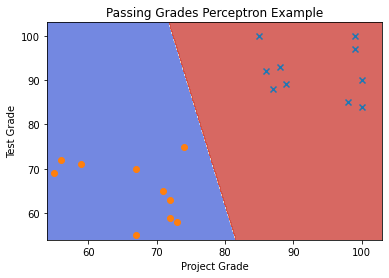

In [4]:
# Establish a mesh for our plot.
x_min, x_max = X.test.min() - 1, X.test.max() + 3
y_min, y_max = X.project.min() - 1, X.project.max() + 3
xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                     np.arange(y_min, y_max, .1))

# Predict over that mesh.
Z = (perceptron.predict(np.c_[xx.ravel(), yy.ravel()])=='pass')


# Reshape the prediction to be plottable.
Z = Z.reshape(xx.shape)

# Plot the mesh.
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Plot our two scatters.
plt.scatter(test_data.project[0:10], test_data.test[0:10], marker='x')
plt.scatter(test_data.project[10:20], test_data.test[10:20], marker='o')

# Aesthetics.
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel('Project Grade')
plt.ylabel('Test Grade')
plt.title('Passing Grades Perceptron Example')
plt.show()

# Supervised Neural Networks

In [5]:
artworks = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Artworks.csv')
artworks.columns

Index(['Title', 'Artist', 'ConstituentID', 'ArtistBio', 'Nationality',
       'BeginDate', 'EndDate', 'Gender', 'Date', 'Medium', 'Dimensions',
       'CreditLine', 'AccessionNumber', 'Classification', 'Department',
       'DateAcquired', 'Cataloged', 'ObjectID', 'URL', 'ThumbnailURL',
       'Circumference (cm)', 'Depth (cm)', 'Diameter (cm)', 'Height (cm)',
       'Length (cm)', 'Weight (kg)', 'Width (cm)', 'Seat Height (cm)',
       'Duration (sec.)'],
      dtype='object')

In [6]:
# Select Columns.
artworks = artworks[['Artist', 'Nationality', 'Gender', 'Date', 'Department',
                    'DateAcquired', 'URL', 'ThumbnailURL', 'Height (cm)', 'Width (cm)']]

# Convert URL's to booleans.
artworks['URL'] = artworks['URL'].notnull()
artworks['ThumbnailURL'] = artworks['ThumbnailURL'].notnull()

# Drop films and some other tricky rows.
artworks = artworks[artworks['Department']!='Film']
artworks = artworks[artworks['Department']!='Media and Performance Art']
artworks = artworks[artworks['Department']!='Fluxus Collection']

# Drop missing data.
artworks = artworks.dropna()

artworks.head()

,Artist,Nationality,Gender,Date,Department,DateAcquired,URL,ThumbnailURL,Height (cm),Width (cm)
0,Otto Wagner,(Austrian),(Male),1896,Architecture & Design,1996-04-09,True,True,48.6000,168.9000
1,Christian de Portzamparc,(French),(Male),1987,Architecture & Design,1995-01-17,True,True,40.6401,29.8451
2,Emil Hoppe,(Austrian),(Male),1903,Architecture & Design,1997-01-15,True,True,34.3000,31.8000
3,Bernard Tschumi,(),(Male),1980,Architecture & Design,1995-01-17,True,True,50.8000,50.8000
4,Emil Hoppe,(Austrian),(Male),1903,Architecture & Design,1997-01-15,True,True,38.4000,19.1000


## Building a Model

In [7]:
# Get data types.
artworks.dtypes

Artist           object
Nationality      object
Gender           object
Date             object
Department       object
DateAcquired     object
URL                bool
ThumbnailURL       bool
Height (cm)     float64
Width (cm)      float64
dtype: object

In [8]:
artworks['DateAcquired'] = pd.to_datetime(artworks.DateAcquired)
artworks['YearAcquired'] = artworks.DateAcquired.dt.year
artworks['YearAcquired'].dtype

dtype('int64')

In [9]:
# Remove multiple nationalities, genders, and artists.
artworks.loc[artworks['Gender'].str.contains('\) \('), 'Gender'] = '\(multiple_persons\)'
artworks.loc[artworks['Nationality'].str.contains('\) \('), 'Nationality'] = '\(multiple_nationalities\)'
artworks.loc[artworks['Artist'].str.contains(','), 'Artist'] = 'Multiple_Artists'

# Convert dates to start date, cutting down number of distinct examples.
artworks['Date'] = pd.Series(artworks.Date.str.extract(
    '([0-9]{4})', expand=False))[:-1]

# Final column drops and NA drop.
X = artworks.drop(['Department', 'DateAcquired', 'Artist', 'Nationality', 'Date'], 1)

# Create dummies separately.
artists = pd.get_dummies(artworks.Artist)
nationalities = pd.get_dummies(artworks.Nationality)
dates = pd.get_dummies(artworks.Date)

# Concat with other variables, but artists slows this wayyyyy down so we'll keep it out for now
X = pd.get_dummies(X, sparse=True)
X = pd.concat([X, nationalities, dates], axis=1)

Y = artworks.Department

MLP = Multi-Layer Perceptron

In [10]:
# Alright! We've done our prep, let's build the model.
# Neural networks are hugely computationally intensive.
# This may take several minutes to run.

# Import the model.
from sklearn.neural_network import MLPClassifier

# Establish and fit the model, with a single, 1000 perceptron layer.
mlp = MLPClassifier(hidden_layer_sizes=(1000,))
mlp.fit(X, Y)

C:\Users\Kuebic\anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Kuebic\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(hidden_layer_sizes=(1000,))

In [11]:
mlp.score(X, Y)

C:\Users\Kuebic\anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


0.7726006746881635

In [12]:
Y.value_counts()/len(Y)

Drawings & Prints        0.622800
Photography              0.225837
Architecture & Design    0.113383
Painting & Sculpture     0.033578
Media and Performance    0.004403
Name: Department, dtype: float64

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(mlp, X, Y, cv=5)

C:\Users\Kuebic\anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Kuebic\anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Kuebic\anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\Users\Kuebic\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Kuebic\anaconda3\lib\site-packages\sklearn\utils\validatio

array([0.71092422, 0.74165824, 0.68604651, 0.67253424, 0.53322916])

In [14]:
X.head()

,URL,ThumbnailURL,Height (cm),Width (cm),YearAcquired,Gender_(),Gender_(Female),Gender_(Male),Gender_(male),Gender_\(multiple_persons\),...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,True,True,48.6000,168.9000,1996,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,True,True,40.6401,29.8451,1995,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,True,True,34.3000,31.8000,1997,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,True,True,50.8000,50.8000,1995,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,True,True,38.4000,19.1000,1997,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
